<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/LayoutLmV3_Finetune_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install pytorch_lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from transformers import AutoProcessor, LayoutLMv3ForTokenClassification
from datasets import load_dataset, load_metric
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt

from datasets.features import ClassLabel
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Helper functions

In [3]:
def un_normalize_box(bbox, width, height):
  return [
    width * (bbox[0] / 1000),
    height * (bbox[1] / 1000),
    width * (bbox[2] / 1000),
    height * (bbox[3] / 1000)
  ]

In [4]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

# Load data & EDA

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

In [6]:
# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Reusing dataset funsd (/root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

In [8]:
dataset["train"].features

{'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

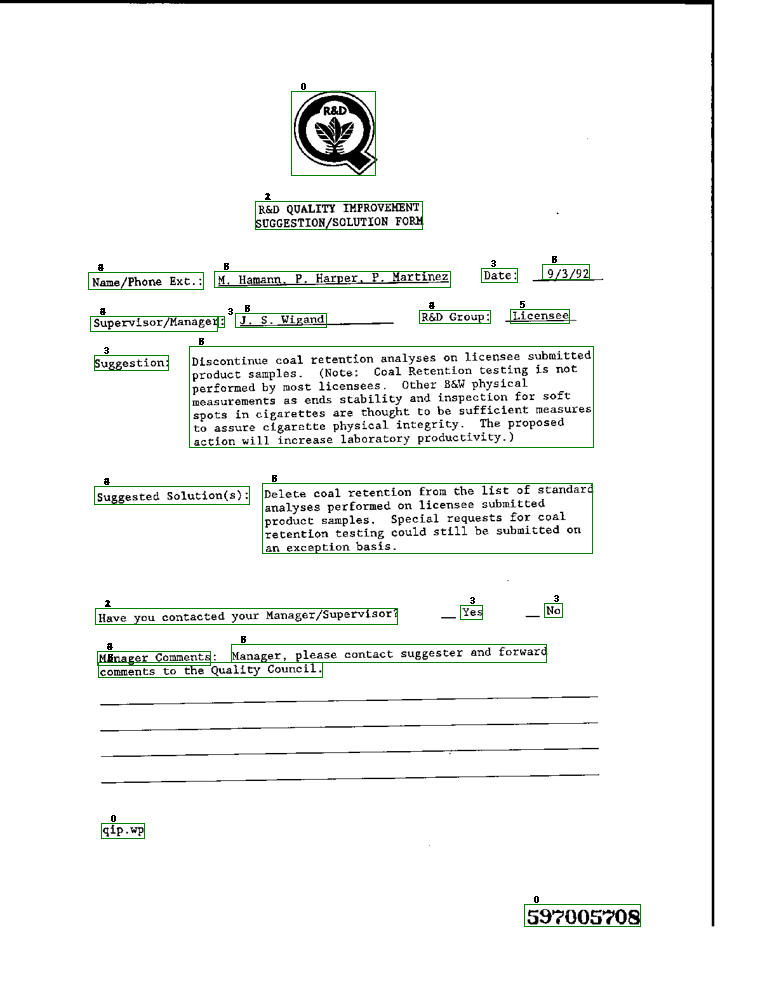

In [9]:
example = dataset["train"][0]

image = example['image']
bbox = example['bboxes']
labels = example['ner_tags']

width, height = image.size
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for box, label in zip(bbox, labels):
  norm_box = un_normalize_box(box, width, height)
  draw.rectangle(norm_box, outline='green')
  draw.text((norm_box[0] + 10, norm_box[1] - 10), text=str(label), fill='black', bfont=font)

image

In [10]:
words = example['tokens']
' '.join(words)

'R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp'

In [11]:
for box, word, label in zip(bbox, words, labels):
  print(box, word, label)

[383, 91, 493, 175] R&D 0
[287, 316, 295, 327] : 3
[124, 355, 221, 370] Suggestion: 3
[632, 268, 679, 282] Date: 3
[670, 309, 748, 323] Licensee 5
[604, 605, 633, 619] Yes 3
[715, 603, 738, 617] No 3
[688, 904, 841, 926] 597005708 0
[335, 201, 555, 229] R&D 1
[335, 201, 555, 229] QUALITY 2
[335, 201, 555, 229] IMPROVEMENT 2
[335, 201, 555, 229] SUGGESTION/ 2
[335, 201, 555, 229] SOLUTION 2
[335, 201, 555, 229] FORM 2
[116, 272, 267, 289] Name 3
[116, 272, 267, 289] / 4
[116, 272, 267, 289] Phone 4
[116, 272, 267, 289] Ext. 4
[116, 272, 267, 289] : 4
[282, 271, 591, 287] M. 5
[282, 271, 591, 287] Hamann 6
[282, 271, 591, 287] P. 6
[282, 271, 591, 287] Harper, 6
[282, 271, 591, 287] P. 6
[282, 271, 591, 287] Martinez 6
[712, 264, 774, 279] 9/ 5
[712, 264, 774, 279] 3/ 6
[712, 264, 774, 279] 92 6
[551, 310, 644, 323] R&D 3
[551, 310, 644, 323] Group: 4
[309, 313, 429, 327] J. 5
[309, 313, 429, 327] S. 6
[309, 313, 429, 327] Wigand 6
[119, 316, 286, 331] Supervisor 3
[119, 316, 286, 331] /

# Build dataset

In [12]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [13]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

In [14]:
if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}

num_labels = len(label_list)

In [15]:
label_list, id2label

(['O',
  'B-HEADER',
  'I-HEADER',
  'B-QUESTION',
  'I-QUESTION',
  'B-ANSWER',
  'I-ANSWER'],
 {0: 'O',
  1: 'B-HEADER',
  2: 'I-HEADER',
  3: 'B-QUESTION',
  4: 'I-QUESTION',
  5: 'B-ANSWER',
  6: 'I-ANSWER'})

In [16]:
def prepare_examples(examples):
  image = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]
  return processor(image, words, boxes=boxes, word_labels=word_labels, truncation=True, padding='max_length')

In [17]:
# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype='float32', shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = dataset['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset['test'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9/cache-7b4f045072937cd1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9/cache-b04435a54af4a21d.arrow


In [18]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [19]:
example = train_dataset[0]
processor.tokenizer.decode(example['input_ids'])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><p

In [20]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [21]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Build lightning datamodule

In [22]:
class FunsdDataMoudule(pl.LightningDataModule):
  def __init__(
      self, train_dataset, eval_dataset,
      batch_size:int=32
  ):
    super(FunsdDataMoudule, self).__init__()
    self.train_dataset = train_dataset
    self.eval_dataset = eval_dataset
    self.batch_size = batch_size

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, pin_memory=True,
        shuffle=True, batch_size=self.batch_size,
        num_workers=2
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.eval_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

In [23]:
datamodule = FunsdDataMoudule(train_dataset, eval_dataset, batch_size=4)

# Build model

In [24]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", id2label=id2label, label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
metric = load_metric("seqeval")

In [26]:
class LayoutLmv3LightningModule(pl.LightningModule):
  def __init__(self, model, lr=5e-5):
    super(LayoutLmv3LightningModule, self).__init__()

    self.model = model
    self.lr = lr

  def forward(self, pixel_values, input_ids, attention_mask, bbox, labels=None):
    return self.model(
        pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask,
        bbox=bbox, labels=labels
    )

  def training_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    loss = outputs.loss
    logits = outputs.logits

    return loss

  def validation_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    results = self.compute_metrics(logits, label)

    self.log('val_acc', results['accuracy'], prog_bar=True, logger=True)
    self.log('val_f1', results['f1'], prog_bar=True, logger=True)

    return val_loss

  def test_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    results = self.compute_metrics(logits, label)

    self.log('test_acc', results['accuracy'], prog_bar=True, logger=True)
    self.log('test_f1', results['f1'], prog_bar=True, logger=True)
    self.log('test_recall', results['recall'], prog_bar=True, logger=True)
    self.log('test_precision', results['precision'], prog_bar=True, logger=True)

  def compute_metrics(self, predictions:torch.Tensor, labels:torch.Tensor) -> dict:
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

  def configure_optimizers(self):
      return {
          'optimizer': torch.optim.AdamW(self.parameters(), lr=self.lr)
      }

In [27]:
layout_module = LayoutLmv3LightningModule(model, lr=1e-5)

# Define trainer

In [28]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

trainer = pl.Trainer(
    max_epochs=9,
    accelerator='gpu', devices=1,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(layout_module, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | LayoutLMv3ForTokenClassification | 125 M 
-----------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
501.329   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default fo

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
trainer.test(layout_module, datamodule.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default fo

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8662063479423523
         test_f1            0.9020979009494261
     test_precision         0.8922866133222255
       test_recall          0.9134500877360477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8662063479423523,
  'test_f1': 0.9020979009494261,
  'test_precision': 0.8922866133222255,
  'test_recall': 0.9134500877360477}]

In [31]:
!nvidia-smi

Sat Jun  4 18:31:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   1450MiB / 15109MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inference

In [32]:
layout_module.eval()
layout_module.cuda();

In [33]:
test_example = np.random.choice(dataset['test'])

encoding = processor(
    test_example['image'], test_example['tokens'], boxes=test_example['bboxes'], word_labels=test_example['ner_tags'],
    return_tensors='pt'
)

encoding['input_ids'] = encoding['input_ids'].cuda()
encoding['attention_mask'] = encoding['attention_mask'].cuda()
encoding['bbox'] = encoding['bbox'].cuda()
encoding['pixel_values'] = encoding['pixel_values'].cuda()
encoding['labels'] = encoding['labels'].cuda()

with torch.no_grad():
  outputs = layout_module(**encoding)

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [34]:
outputs.logits

tensor([[[-7.5828e-02, -3.5782e-01, -3.2199e-01, -7.0401e-01, -6.7433e-01,
          -4.1445e-01,  1.4454e-01],
         [ 4.6246e+00, -1.5215e+00, -1.5601e+00, -9.5199e-01, -5.1764e-01,
           2.9230e-01,  5.6890e-01],
         [ 4.3110e+00, -2.1064e+00, -1.4765e+00, -1.5166e+00, -1.9795e-01,
          -3.3347e-01,  1.1566e+00],
         [ 3.8778e+00, -2.3045e+00, -1.6281e+00, -1.4665e+00, -2.1324e-01,
          -4.1640e-01,  1.6149e+00],
         [ 3.7379e+00, -2.3672e+00, -1.4250e+00, -1.3538e+00,  7.1999e-02,
          -2.1236e-01,  1.7029e+00],
         [ 1.2580e-01,  2.8573e+00, -1.5810e+00,  3.9650e+00, -2.2858e+00,
          -9.9017e-01, -2.4278e+00],
         [ 8.6090e-01,  5.4761e-02,  1.4423e+00, -2.1122e-01,  2.5405e+00,
          -2.5593e+00, -1.6342e+00],
         [ 1.4674e+00, -1.5731e+00,  1.7404e+00, -1.2167e+00,  3.5600e+00,
          -2.7325e+00, -9.9564e-01],
         [-4.1234e-03,  6.1030e-01, -1.9830e+00,  5.3976e+00, -1.5806e+00,
          -1.4977e-01, -2.196

In [35]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
print(predictions)

[6, 0, 0, 0, 0, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 5, 6, 6, 6, 3, 4, 4, 4, 4, 5, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 5, 6, 6, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 6]


In [36]:
image = test_example['image']

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [un_normalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

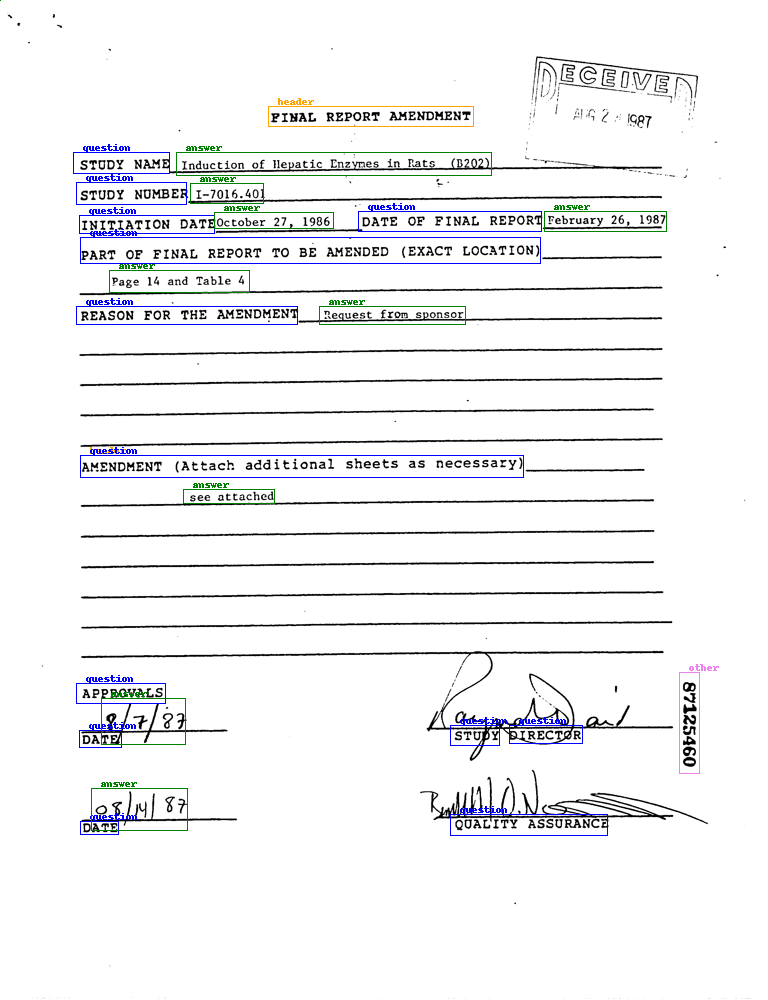

In [37]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

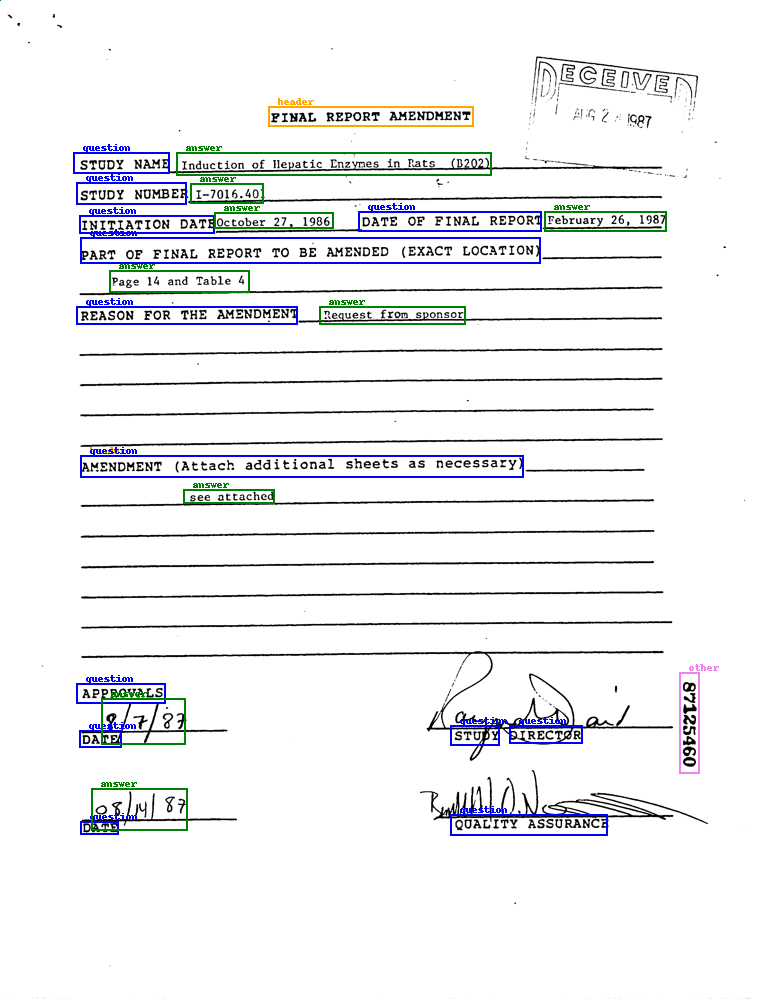

In [38]:
# Compare with ground truth
image = test_example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(test_example['tokens'], test_example['bboxes'], test_example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = un_normalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image